#### Importing Librarires 

In [15]:
import gym
import sys
import sys
import random

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn 
import torch.nn.functional as F 
from torch.distributions.categorical import Categorical
from sklearn.preprocessing import normalize

import math as mt
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
import qiskit_machine_learning
from qiskit_machine_learning.neural_networks import SamplerQNN, CircuitQNN
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
class HybridActorNetwork(nn.Module):
    def __init__(self, 
                 state_space, 
                 action_space,
                 number_of_qubits = 1,
                 number_of_shots = 1024):
        super(HybridActorNetwork, self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.number_of_qubits = number_of_qubits
        self.number_of_shots = number_of_shots

        self.qubits = [i for i in range(0, self.number_of_qubits)]
        self.quantum_circuit = qiskit.QuantumCircuit(self.number_of_qubits)
        self.theta = qiskit.circuit.Parameter('theta')
        self.beta = qiskit.circuit.ParameterVector('beta', self.state_space)

        self.input_layer()
        self.parameterized_quantum_circuit()
        quantum_neural_network = EstimatorQNN(circuit = self.quantum_circuit, 
                                              input_params = self.beta.params, 
                                              weight_params = [self.theta], 
                                              input_gradients = True)
        self.quantum_layer = TorchConnector(quantum_neural_network)

        self.classical_layer_1 = nn.Linear(64, 128)
        self.classical_layer_2 = nn.Linear(128, self.action_space)

    def input_layer(self):
        self.quantum_circuit.h(self.qubits)
        self.quantum_circuit.barrier()

        self.quantum_circuit.rz(self.beta[0], self.qubits)
        self.quantum_circuit.ry(self.beta[1], self.qubits)
        self.quantum_circuit.rz(self.beta[2], self.qubits)
        self.quantum_circuit.barrier()

    def parameterized_quantum_circuit(self):
        self.quantum_circuit.rx(self.theta, self.qubits)
        self.quantum_circuit.barrier()

    def forward(self, current_state):
        output_layer_1 = self.quantum_layer(current_state)
        output_layer_1 = output_layer_1.repeat(64)
        output_layer_2 = F.relu(self.classical_layer_1(output_layer_1))
        output_layer_3 = self.classical_layer_2(output_layer_2)
        
        policy = Categorical(F.softmax(output_layer_3, dim=-1))
        return policy

In [18]:
class HybridCriticNetwork(nn.Module):
    def __init__(self, 
                 state_space, 
                 action_space,
                 number_of_qubits = 1,
                 number_of_shots = 1024):
        super(HybridCriticNetwork, self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.number_of_qubits = number_of_qubits
        self.number_of_shots = number_of_shots

        self.qubits = [i for i in range(0, self.number_of_qubits)]
        self.quantum_circuit = qiskit.QuantumCircuit(self.number_of_qubits)
        self.theta = qiskit.circuit.Parameter('theta')
        self.beta = qiskit.circuit.ParameterVector('beta', self.state_space)

        self.input_layer()
        self.parameterized_quantum_circuit()
        quantum_neural_network = EstimatorQNN(circuit = self.quantum_circuit, 
                                              input_params = self.beta.params, 
                                              weight_params = [self.theta], 
                                              input_gradients = True)
        self.quantum_layer = TorchConnector(quantum_neural_network)

        self.classical_layer_1 = nn.Linear(64, 128)
        self.classical_layer_2 = nn.Linear(128, 1)

    def input_layer(self):
        self.quantum_circuit.h(self.qubits)
        self.quantum_circuit.barrier()

        self.quantum_circuit.rz(self.beta[0], self.qubits)
        self.quantum_circuit.ry(self.beta[1], self.qubits)
        self.quantum_circuit.rz(self.beta[2], self.qubits)
        self.quantum_circuit.barrier()

    def parameterized_quantum_circuit(self):
        self.quantum_circuit.rx(self.theta, self.qubits)
        self.quantum_circuit.barrier()

    def forward(self, current_state):
        output_layer_1 = self.quantum_layer(current_state)
        output_layer_1 = output_layer_1.repeat(64)
        output_layer_2 = F.relu(self.classical_layer_1(output_layer_1))
        state_value = self.classical_layer_2(output_layer_2)
    
        return state_value

In [19]:
class QERL_Agent():
    def __init__(self, 
                 Actor,
                 Critic,
                 max_time_steps,
                 actor_learning_rate,
                 critic_learning_rate,
                 discount_factor,
                 number_of_epochs):
        
        self.max_time_steps = max_time_steps
        self.actor_learning_rate = actor_learning_rate
        self.critic_learning_rate = critic_learning_rate
        self.discount_factor = discount_factor
        self.number_of_epochs = number_of_epochs

        self.Actor = Actor
        self.Critic = Critic

        self.actor_optimizer = optim.Adam(self.Actor.parameters(), self.actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.Critic.parameters(), self.critic_learning_rate)

    def clear_memory(self):
        self.rewards = []
        self.state_values = []
        self.log_policies = []
        self.done = []

    def replay_memory(self, 
                      state_value,
                      reward,
                      policy,
                      done):
        
        self.log_policies.append(policy)
        self.state_values.append(state_value)
        self.rewards.append(torch.tensor([reward],
                                         dtype = torch.float,
                                         device = device))
        self.done.append(torch.tensor([1-done],
                                      dtype = torch.float,
                                      device = device))
        
    def action_selection(self, 
                         current_state):
        current_state = torch.FloatTensor(current_state).to(device)
        policy = self.Actor(current_state)
        action = policy.sample()
        policy = policy.log_prob(action).unsqueeze(0)

        return action.cpu().numpy(), policy
    
    def compute_discounted_rewards(self, 
                                   next_state_value):
        R = next_state_value
        discounted_rewards = []
        for step in reversed(range(len(self.rewards))):
            R = self.rewards[step] + self.discount_factor * R * self.done[step]
            discounted_rewards.insert(0, R)
        return discounted_rewards
    
    def loss_function(self,
                      discounted_rewards):
        
        self.log_policies = torch.cat(self.log_policies)
        discounted_rewards = torch.cat(discounted_rewards).detach()
        self.state_values = torch.cat(self.state_values)

        advantage = discounted_rewards - self.state_values
        actor_loss = -(self.log_policies * advantage.detach()).mean()
        critic_loss = F.huber_loss(discounted_rewards, self.state_values)

        return actor_loss, critic_loss
    
    def training(self, next_state_value):
        discounted_rewards = self.compute_discounted_rewards(next_state_value)
        actor_loss, critic_loss = self.loss_function(discounted_rewards)

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        return actor_loss.item(), critic_loss.item()

In [20]:
def data_transformation(state):
        return [mt.atan(i) for i in state] 

In [22]:
enviroment = gym.make("CartPole-v0").unwrapped

state_space = enviroment.observation_space.shape[0]-1
action_space = enviroment.action_space.n

actor_learning_rate = 0.001
critic_learning_rate = 0.01

max_time_steps = 500
number_of_epochs = 1
number_of_episodes = 500
discount_factor = 0.99
constant_for_average = 10

Actor = HybridActorNetwork(state_space = state_space,
                     action_space = action_space).to(device)
Critic = HybridCriticNetwork(state_space = state_space,
                       action_space = action_space).to(device)
Agent = QERL_Agent(Actor = Actor,
                        Critic = Critic,
                        max_time_steps = max_time_steps,
                        discount_factor = discount_factor,
                        actor_learning_rate = actor_learning_rate,
                        critic_learning_rate = critic_learning_rate,
                        number_of_epochs = number_of_epochs)

score = []
actor_loss = []
critic_loss = []

average_score = []
average_actor_loss = []
average_critic_loss = []

for current_episode in range(0, number_of_episodes):
    Agent.clear_memory()
    (current_state, _ ) = enviroment.reset()
    episodic_score  = 0

    for time_step in range(0, max_time_steps):
        enviroment.render()
        current_state = data_transformation(state = current_state[1:4])
        action, policy = Agent.action_selection(current_state)
        current_state = torch.FloatTensor(current_state).to(device)
        state_value = Critic(current_state)

        next_state, reward, done, info, _ = enviroment.step(action)
        episodic_score += reward

        Agent.replay_memory(reward = reward,
                            policy = policy,
                            state_value = state_value,
                            done = done)
        
        current_state = next_state
        if done == True:
            break

    next_state = data_transformation(state = next_state[1:4])
    next_state = torch.FloatTensor(next_state).to(device)
    next_state_value = Critic(next_state)
    episodic_actor_loss, episodic_critic_loss = Agent.training(next_state_value = next_state_value)

    score.append(episodic_score)
    actor_loss.append(episodic_actor_loss)
    critic_loss.append(episodic_critic_loss)
    print('Episode:{} Score:{} Actor_Loss:{} Critic_Loss:{}'.format(current_episode, 
                                                                    episodic_score, 
                                                                    episodic_actor_loss, 
                                                                    episodic_critic_loss))
    
for i in range(0,int(len(score)/constant_for_average)):
    temp_score = sum(score[i * constant_for_average : (i+1) * constant_for_average])
    temp_actor_loss = sum(actor_loss[i * constant_for_average : (i+1) * constant_for_average])
    temp_critic_loss = sum(critic_loss[i * constant_for_average : (i+1) * constant_for_average])

    average_score.append(temp_score/10)
    average_actor_loss.append(temp_actor_loss/10)
    average_critic_loss.append(temp_critic_loss/10)

Episode:0 Score:14.0 Actor_Loss:4.717113494873047 Critic_Loss:6.675096035003662
Episode:1 Score:19.0 Actor_Loss:6.641137599945068 Critic_Loss:8.938326835632324
Episode:2 Score:14.0 Actor_Loss:4.480010986328125 Critic_Loss:6.338454246520996
Episode:3 Score:17.0 Actor_Loss:5.881042957305908 Critic_Loss:7.743668556213379
Episode:4 Score:13.0 Actor_Loss:3.956125020980835 Critic_Loss:5.60426664352417
Episode:5 Score:12.0 Actor_Loss:4.393077850341797 Critic_Loss:5.314713001251221
Episode:6 Score:14.0 Actor_Loss:4.674781799316406 Critic_Loss:5.99718713760376
Episode:7 Score:10.0 Actor_Loss:3.3644893169403076 Critic_Loss:3.9894137382507324
Episode:8 Score:23.0 Actor_Loss:7.0864033699035645 Critic_Loss:9.57313060760498
Episode:9 Score:41.0 Actor_Loss:11.999899864196777 Critic_Loss:16.615209579467773
Episode:10 Score:36.0 Actor_Loss:10.636981964111328 Critic_Loss:14.596479415893555
Episode:11 Score:19.0 Actor_Loss:5.147160530090332 Critic_Loss:7.174704074859619
Episode:12 Score:12.0 Actor_Loss:2

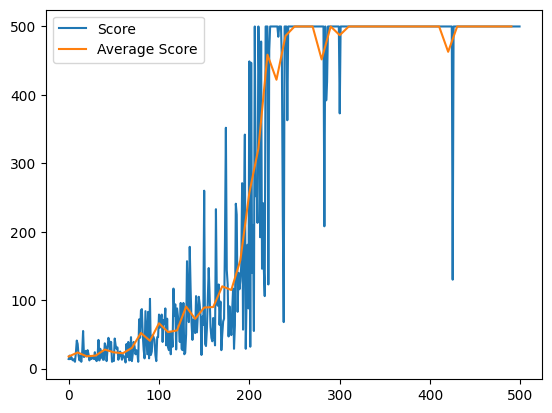

In [23]:
plt.plot(np.array(list(range(0, len(score)))), score, label='Score')
plt.plot(np.array(list(range(0, len(score), constant_for_average))), average_score, label='Average Score')
plt.legend()
plt.show()

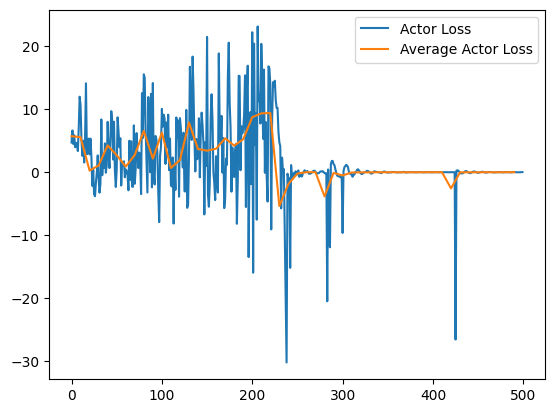

In [24]:
plt.plot(np.array(list(range(0, len(actor_loss)))), actor_loss, label='Actor Loss')
plt.plot(np.array(list(range(0, len(actor_loss), constant_for_average))), average_actor_loss, label='Average Actor Loss')
plt.legend()
plt.show()

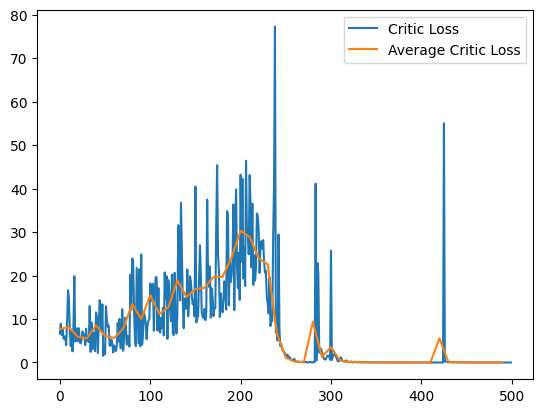

In [25]:
plt.plot(np.array(list(range(0, len(critic_loss)))), critic_loss, label='Critic Loss')
plt.plot(np.array(list(range(0, len(critic_loss), constant_for_average))), average_critic_loss, label='Average Critic Loss')
plt.legend()
plt.show()

In [26]:
torch.save(Actor, 'Hybrid_Actor_Network_V7(500_Episodes_2_classical_layers).pkl')
torch.save(Critic, 'Hybrid_Critic_Network_V7(500_Episodes_2_classical_layers).pkl')

In [27]:

file = open("Quantum_Score_Loss_V7(500_Episodes_2_classical_layers).txt", "x")
data = np.column_stack([score, actor_loss, critic_loss])
np.savetxt("Quantum_Score_Loss_V7(500_Episodes_2_classical_layers).txt",data)

In [28]:
total_params = sum(p.numel() for p in Actor.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 8579


In [29]:
total_params = sum(p.numel() for p in Critic.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 8450


In [ ]:
print("Hello")